In [1]:
from envs.graph.cells_policy import ForwardPolicy, BackwardPolicy
from envs.graph.moving_cells import MovingCells

from gflownet.gflownet import GFlowNet
from gflownet.utils import trajectory_balance_loss

from torch.optim import RMSprop
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from torch.nn.functional import one_hot
import torch

import matplotlib.pyplot as plt

from torch_geometric.nn import radius_graph
from torch_geometric.data import Data

from torch_geometric.utils import to_networkx
import networkx as nx

import time

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train (device, model, opt, opt_args, num_epochs, batch_size, offset=0) :
  print ("Training the model on ", device)
  #compute the time taken to train the model
  time_in = time.time()
  model = model.to(device)
  
  opt = opt(model.parameters(), **opt_args)
  scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2)
  
  graph_size = model.env.graph_size
  edge_distance = model.env.edge_distance
  
  for i in range(offset, num_epochs + offset):
    s0 = torch.rand(batch_size, int(torch.floor(torch.tensor(graph_size ** 2 / 2)).item()), 2).to(device)
    #fill s0 with nans to have batch_size * graph_size ** 2 * 2 elements
    s0 = torch.cat((s0, torch.empty(batch_size, int(torch.ceil(torch.tensor(graph_size ** 2 / 2)).item()), 2).to(device).fill_(float('nan'))), dim=1)
    iteration_number = torch.zeros(batch_size, 1, 2).to(device)
    s0 = torch.cat((iteration_number, s0), dim=1)
    s0 = s0.view(batch_size, -1)
    
    s, log = model.sample_states(s0, return_log=True)
   
    loss = trajectory_balance_loss(log.total_flow, log.rewards, log.fwd_probs, log.back_probs)
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    scheduler.step(i)
    
    print("Epoch: ", i, "Loss: ", loss.item(), "Lr: ", scheduler.get_last_lr(), end='\r')
  time_out = time.time() - time_in
  print("\nTime taken to train the model: ", time_out)
  
  return model

In [3]:
def test(device, model, test_size, fig_name, seed = None) :
    with torch.no_grad() : 
        model = model.to(device)
        
        graph_size = model.env.graph_size
        edge_distance = model.env.edge_distance
        
        if seed is not None :
            generator = torch.manual_seed(seed)
            s0 = torch.rand(test_size, int(torch.floor(torch.tensor(graph_size ** 2 / 2)).item()), 2, generator = generator).to(device)
        else : 
            s0 = torch.rand(test_size, int(torch.floor(torch.tensor(graph_size ** 2 / 2)).item()), 2).to(device)
        #fill s0 with nans to have test_size * graph_size ** 2 * 2 elements
        s0 = torch.cat((s0, torch.empty(test_size, int(torch.ceil(torch.tensor(graph_size ** 2 / 2)).item()), 2).to(device).fill_(float('nan'))), dim=1)
        iteration_number = torch.zeros(test_size, 1, 2).to(device)
        s0 = torch.cat((iteration_number, s0), dim=1)
        
        s0 = s0.view(test_size, -1)
        s = model.sample_states(s0)
        
        s = s.cpu()
        model.env.plot(s, fig_name)

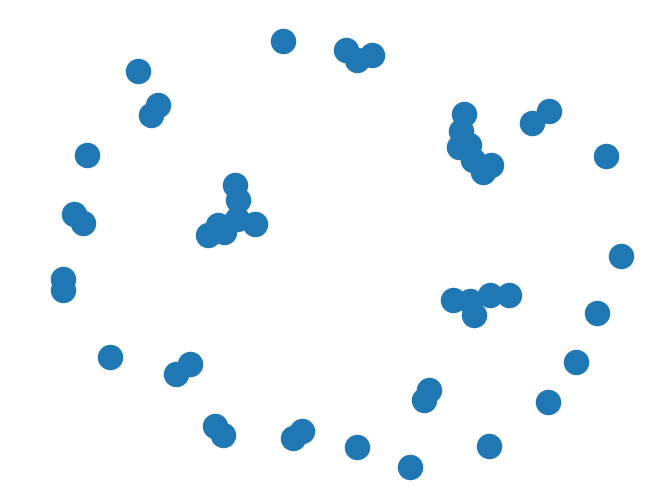

In [4]:
num_epochs = 10
batch_size = 4
hidden_dim = 32

graph_size = 10
edge_distance = 0.1
env = MovingCells(graph_size, edge_distance) 

test_size = 10**2

backward_policy = BackwardPolicy(env.num_actions, env.graph_size)
forward_policy = ForwardPolicy(env.num_actions, env.graph_size, env.edge_distance, hidden_dim)

model = GFlowNet(forward_policy, backward_policy, env)

initial_pos =  torch.rand(graph_size ** 2 // 2, 2)

initial_edge_index = radius_graph(initial_pos, r=edge_distance, max_num_neighbors=32, loop=False)
initial_edge_attr = torch.norm(initial_pos[initial_edge_index[0]] - initial_pos[initial_edge_index[1]], dim=1).unsqueeze(1)

initial_graph = Data(pos=initial_pos, 
                        edge_index=initial_edge_index,
                        edge_attr=initial_edge_attr,
                        updates = 0)

g = to_networkx(initial_graph, to_undirected=True)
nx.draw(g)

Training the model on  cuda
Epoch:  9 Loss:  877.621826171875 Lr:  [2.4471741852423235e-05]]
Time taken to train the model:  7.85642147064209


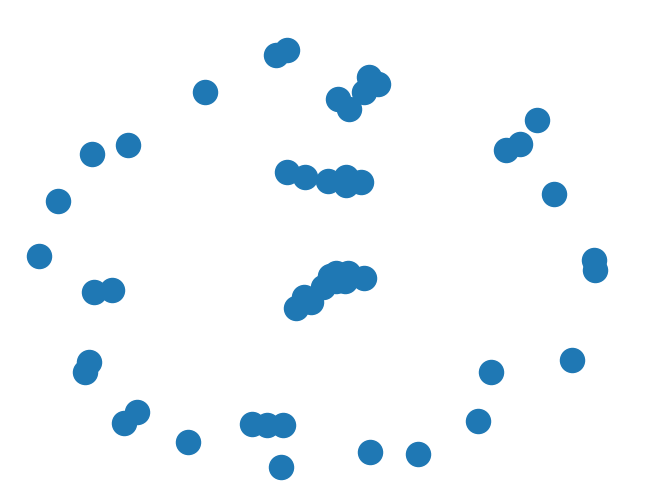

Training the model on  cuda
Epoch:  19 Loss:  2047.13330078125 Lr:  [0.0005782172325201155]7]
Time taken to train the model:  5.614753007888794


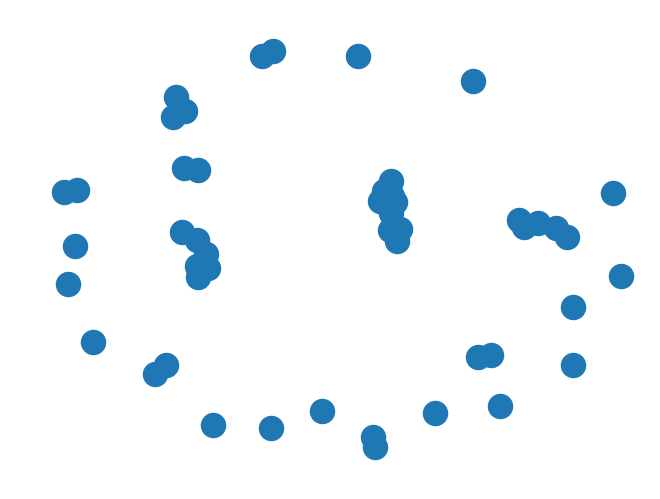

Training the model on  cuda
Epoch:  29 Loss:  175.14125061035156 Lr:  [6.15582970243117e-06]]]
Time taken to train the model:  9.175994873046875


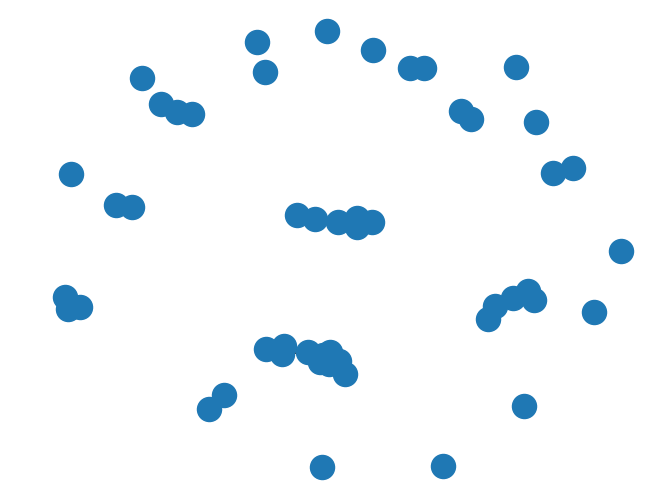

Training the model on  cuda
Epoch:  39 Loss:  0.009080668911337852 Lr:  [0.0008802029828000156]
Time taken to train the model:  9.384479999542236


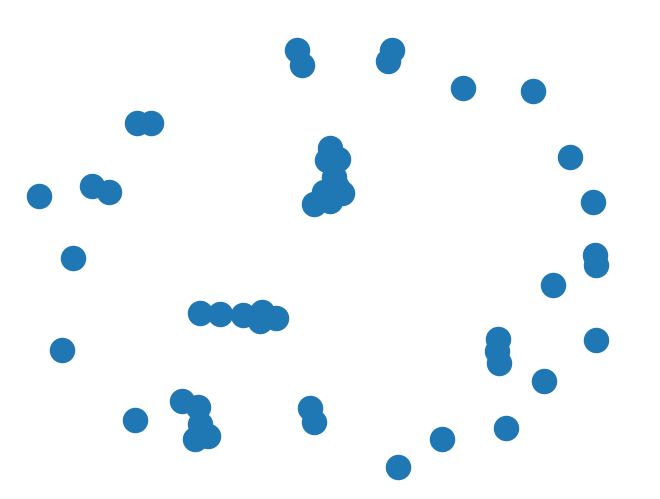

Training the model on  cuda
Epoch:  49 Loss:  687.2908325195312 Lr:  [0.0005392295478639225]]7]
Time taken to train the model:  5.481037855148315


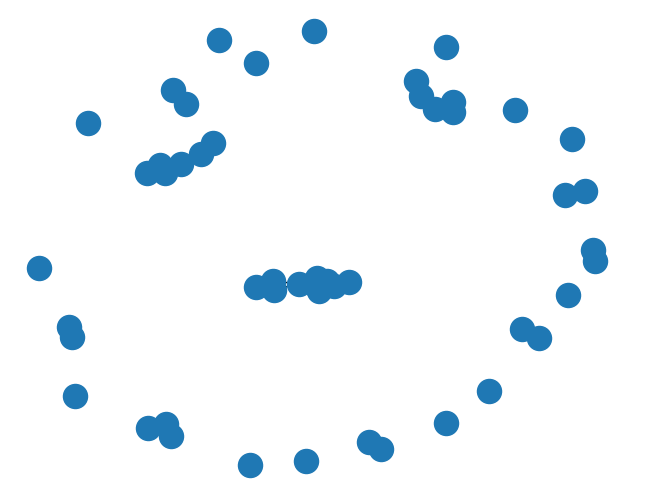

In [5]:
for i in range(5):
    model = train("cuda" if torch.cuda.is_available else "cpu", model, RMSprop, {"lr": 1e-3}, num_epochs, batch_size, i * num_epochs)

    test("cpu", model, test_size, "test.png", seed = 0)